# **Deep Learning Homework 5: *Autoencoders***
### MSc Computer Science, Data Science, Cybersecurity Computer Engeneering @UniPD
### 2nd semester - 6 ECTS
### Prof. Alessandro Sperduti & Prof. Nicolò Navarin and Dr. Luca Pasa
---


In this homework, we will deal with _dimensionality reduction_ and learn how to develop a simple _Autoencoder_.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Finally, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder).

#Requirements

In [ ]:
!pip3 install datasets skorch pandas~=1.5 torch~=1.13 torchinfo torchdata~=0.5 torchtext~=0.14 torchvision~=0.14 torchaudio~=0.13

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 90.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━

#Imports

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torchinfo import summary
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

# Data Loading

We load the `CIFAR-10 dataset`, available from `torchvision.datasets`. This dataset is one of the most popular benckmark in the filed of Computer Vision. It consits of $10$ different classes, that represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The dataset contains $50,000$ training images and $10,000$ images for testing.

First, we will pre-process them with a `PreProcessing` fuction that works in the following way. The images are originally in RGB format, but we will convert them to grayscale for convenience. The value of each pixel is between $0$ and $255$, and it represents a point of an image of size $32\times32$. We will normalize all values between $0$ and $1$, and we will flatten the $32\times32$ images into vectors of size $1024$.
Moreover, since no validation set is defined, we split the train set in a validation set and a new test set.
Finally, we design a custom dataset class, derived from the standard `Dataset` class, that returns a PyTorch Dataset object, along with its noisy version. The Gaussian noise is tunable with the `noise_factor` parameter and will be used for the Denoising Autoencoder.

In [ ]:
to_tensor = transforms.ToTensor()

def PreProcessing(img):
  img = to_tensor(img) # PIL to tensor + scaling
  img = torch.mean(img, 0) # one channel averaged over the colors
  img = img.reshape(torch.prod(torch.tensor(img.shape))) # flattening
  return img.to(torch.float32)

In [ ]:
dataset = CIFAR10(root='data/', download=True, train=True, transform=transforms.Lambda(PreProcessing)) # 50000 samples
test_data = CIFAR10(root='data/', download=True, train=False, transform=transforms.Lambda(PreProcessing)) # 10000 samples

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [ ]:
val_size = 10000
train_size = len(dataset) - val_size

train_data, val_data = random_split(dataset, [train_size, val_size])
print(f"Training samples = {len(train_data)} \nValidation samples = {len(val_data)} \nTest samples = {len(test_data)}")

Training samples = 40000 
Validation samples = 10000 
Test samples = 10000


In [ ]:
class CustomDataset(Dataset):
  def __init__(self, dataset, noise_factor, device='cpu'):
    super().__init__()
    self.dataset = dataset
    self.nf = noise_factor
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, idx):
    x, _ = self.dataset[idx]
    x_noisy = x + self.nf*np.random.normal(loc=0.0, scale=1.0, size=x.shape)
    x_noisy = np.clip(x_noisy, 0., 1.).to(torch.float32)
    return (x.to(device), x_noisy.to(device))

In [ ]:
# Set noise factor for later
noise_factor = 0.1

# [TO COMPLETE] SVD

Similar to Principal component analysis (PCA), Singular Value Decomposition (SVD) is a standard linear dimensionality reduction method. They both linearly combine the features of the original high-dimensional dataset and project them into a lower-dimensional space, ideally retaing most of thier intrinsic properties.

In this first part of the HW, we will focus our attention on SVD decomposition and its performances. Given a matrix $X$, the SVD decomposes it into the product of two unitary matrices, $V$ and $U$, and a rectangular diagonal matrix of singular values $S$:

$$ X=V \cdot S \cdot U^T.$$

The SVD is already implemented in PyTorch as `torch.linalg.svd`. In our case, the $X$ matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features). However, notice that the $X$ matrix has a huge number of rows (we have 50,000 input samples) and only 784 columns. If you are using the _Colab_ free plan, the quantity of available RAM may not be sufficient to compute the SVD of $X$. Therefore, to ease memory consumption and numerical stability, we resort to one property of the SVD and compute its equivalent version from the matrix $C= X^T \cdot X$, that can be decomposed as:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix $U$ to compute the compressed version of our data, this trick turns out to be a quick and good solution.

In [ ]:
def svd_k(X, k): # k: sets the number of components to keep
  # Compute the matrix C
  C = torch.matmul(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = torch.linalg.svd(C)
  # Limit the number columns of U to k
  U_k = U[:, :k]
  return U_k

Now, we create the dataset ready for the SVD.

In [ ]:
device = torch.device("cpu") # for SVD

x_train, x_train_noisy = next(iter(DataLoader(CustomDataset(train_data, noise_factor, device), batch_size=len(train_data))))
x_val, x_val_noisy = next(iter(DataLoader(CustomDataset(val_data, noise_factor, device), batch_size=len(val_data))))
x_test, x_test_noisy = next(iter(DataLoader(CustomDataset(test_data, noise_factor, device), batch_size=len(test_data))))

x_train.shape, x_train_noisy.shape, x_val.shape, x_val_noisy.shape, x_test.shape, x_test_noisy.shape

(torch.Size([40000, 1024]),
 torch.Size([40000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]))

Let's define the `ENCODING_DIM`, that will be the size of the compressed version of input data. And compute the compressed version of the training set and test set.


In [ ]:
### TO COMPLETE [START] ###
# Define the size of the compressed version of input data
ENCODING_DIM = 256
### TO COMPLETE [END] ###

U_k = svd_k(x_train, ENCODING_DIM)

x_training_svd = torch.matmul(x_train, U_k)
x_test_svd = torch.matmul(x_test, U_k)

We now reconstruct back the original input and check how much information was lost due to the compression. We do so by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [ ]:
x_training_reco = torch.matmul(x_training_svd, U_k.T)
x_test_reco = torch.matmul(x_test_svd, U_k.T)

In [ ]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("Training MSE: %.5f" % ( accuracy_train))
print("Test MSE: %.5f" % ( accuracy_test))

Training MSE: 0.00150
Test MSE: 0.00153


In [ ]:
def plot_img(n, images_sets: list, title=""):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    for set_idx, images in enumerate(images_sets):
      ax = plt.subplot(len(images_sets), n, i + 1 + set_idx*n)
      plt.imshow(images[i].reshape(32, 32))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.suptitle(title)
  plt.show()

Let's see how well the input can be reconstructed by displaying a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images corresponds to input data, while the second one contains the reconstructions.

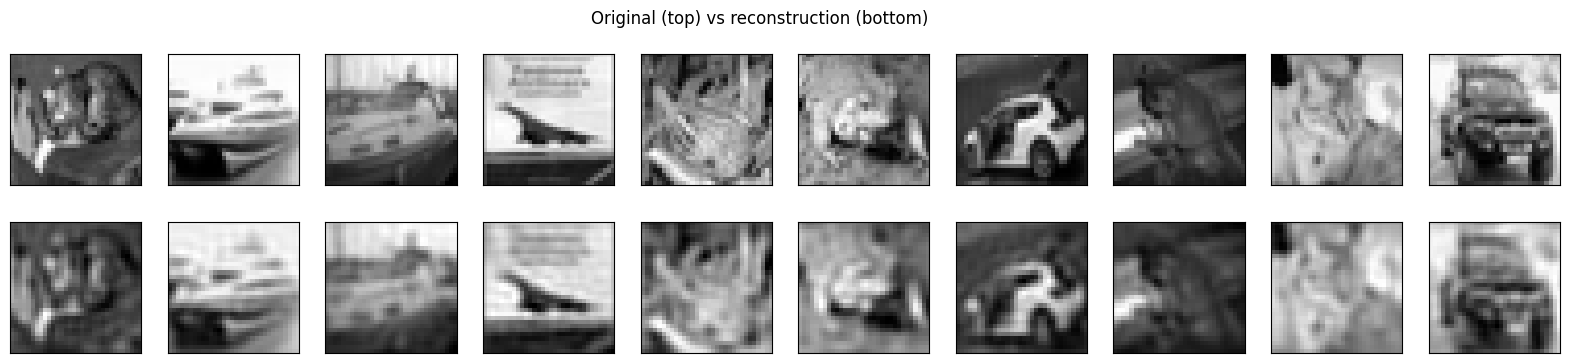

In [ ]:
_ = plot_img(10, [x_test, x_test_reco], title="Original (top) vs reconstruction (bottom)")


**[TO COMPLETE]**: what happens by varying the `ENCODING_DIM`?
 Test and discuss the results in a cell below.

`%STARTEXT`

**Answer**:

Varying the `ENCODING_DIM` parameter in the context of reconstructing from noise can have significant implications. The `ENCODING_DIM` parameter denotes the dimensionality of the compressed representation of the input data. It directly influences the model's capacity to effectively represent and reconstruct the input data.

In general, increasing the `ENCODING_DIM` enhances the model's ability to reconstruct the input data. This is attributed to the higher encoding dimension, which allows the model to capture more intricate details and provide a more accurate representation of the original data.

On the other hand, when the `ENCODING_DIM` is smaller, the compressed representation of the input data has limited capacity to store information, potentially leading to the loss of critical details during the reconstruction process. Consequently, smaller encoding dimensions often result in poorer reconstruction performance.

As a consequence, increasing the `ENCODING_DIM` can lead to progressively better reconstruction results, while reducing it may result in a suboptimal reconstruction of the input data, particularly when dealing with noisy samples.

Given all these observations, when considering a small `ENCODING_DIM`, the inadequacy of the reconstructed input images becomes evident. However, by increasing this value, progressively improved results are obtained. For instance, when `ENCODING_DIM` = 256, great image reconstruction outcomes are achieved.

In the following, the results in terms of Mean Squared Error (MSE) are highlighted as the `ENCODING_DIM` varies.

|ENCODING_DIM|Test MSE|
|-|-|
|2|0.03249|
|8|0.01932|
|32|0.00984|
|64|0.00631|
|128|0.00353|
|256|0.00153|

As can be seen from the results above, by increasing the  `ENCODING_DIM `, progressively better MSE values are obtained for each increment.



`%ENDEXT`

# [TO COMPLETE] Shallow Linear Autoencoder

Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. First, we define the `DataLoader` to train the model.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 512
noise_factor = 0.1 # adjust the noise level here

dataloader_train_AE = DataLoader(CustomDataset(train_data, noise_factor, device), batch_size=batch_size)
dataloader_val_AE = DataLoader(CustomDataset(val_data, noise_factor, device), batch_size=batch_size)
dataloader_test_AE = DataLoader(CustomDataset(test_data, noise_factor, device), batch_size=batch_size)

Then, we build our shallow Autoencoder. Here's a breakdown of the code to help you grasp how it works:

1. The `__init__` method is the initialization function for the Auto_Encoder class. It takes four parameters: `input_dim` (dimensionality of the input data), `enc_layers` (a list specifying the sizes of the encoder layers), `dec_layers` (a list specifying the sizes of the decoder layers), and `act_fun` (the activation function to be used).

2. The `nn.ModuleList()` is used to create empty lists E_layers and D_layers to store the encoder and decoder layers, respectively.

3. The `for loop `iterates over the `enc_layers` list to create the encoder layers. For the first layer, it creates a linear layer (`nn.Linear`) mapping from the input dimension to the size of the first encoder layer. For subsequent layers, it creates linear layers mapping between consecutive encoder layer sizes. The created layers are appended to the `self.E_layers` list.

4. The code then checks if the `dec_layers` list is empty. If it is empty, it creates a single linear layer mapping from the last encoder layer size to the input dimension (remember: the goal of the AE is to reconstruct the input). Otherwise, it iterates over the `dec_layers` list to create the decoder layers, similar to how the encoder layers were created. The last decoder layer is always mapped to the input dimension.

5. The `_init_weights` method is a helper function that initializes the weights of the linear layers. It is applied to all modules (layers) of the Auto_Encoder instance.

6. The `forward` method defines the forward pass of the Autoencoder.

In [ ]:
class Auto_Encoder(nn.Module):

  def __init__(self, input_dim, enc_layers, dec_layers, act_fun):
    super().__init__()

    self.E_layers = nn.ModuleList()
    self.D_layers = nn.ModuleList()
    self.act_fun = act_fun
    activation_functions = {'linear': transforms.Lambda(lambda x: x),
                            'sigmoid': F.sigmoid,
                            'relu': F.relu,
                            'tanh': F.tanh,
                            'leaky_relu': F.leaky_relu}
    assert self.act_fun in activation_functions, f'Activation Functions: {activation_functions.keys()}'
    self.af = activation_functions[self.act_fun]

    for layer_idx in range(len(enc_layers)):
      if layer_idx == 0: # first layer, from input to encoder
        self.E_layers = self.E_layers.append(nn.Linear(input_dim, enc_layers[layer_idx]))
      else: # hidden layers, depending on the input
        self.E_layers = self.E_layers.append(nn.Linear(enc_layers[layer_idx-1], enc_layers[layer_idx]))

    if len(dec_layers) == 0:
      self.D_layers = self.D_layers.append(nn.Linear(enc_layers[-1], input_dim))
    else:
      for layer_idx in range(len(dec_layers)):
        if layer_idx == 0: # first layer, from encoder to decoder
          self.D_layers = self.D_layers.append(nn.Linear(enc_layers[-1], dec_layers[layer_idx]))
        else: # hidden layers, depending on the input
          self.D_layers = self.D_layers.append(nn.Linear(dec_layers[layer_idx-1], dec_layers[layer_idx]))

      self.D_layers = self.D_layers.append(nn.Linear(dec_layers[-1], input_dim)) # final output layer

    self.apply(self._init_weights)

  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
        module.weight.data.normal_(mean=0.0, std=.1)
        if module.bias is not None:
            module.bias.data.zero_()

  def forward(self, x):
    for layer in self.E_layers:
      x = self.af(layer(x))
    for layer in self.D_layers[:-1]:
      x = self.af(layer(x))
    if self.act_fun == 'linear':
      return self.D_layers[-1](x)
    else:
      return F.sigmoid(self.D_layers[-1](x)) # last activation funcion is always sigmoid

**[TO COMPLETE]**: check the results and compare them with the ones obtained with the SVD. In the cell at the end of this section (after the result of the linear autoencoder), give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.

Try also to be aquainted with the usual PyTorch training and evaluation routines. In the following part of the HW, the more training epochs the better the resutls, but it will also take longer. Feel free to change the `epochs` variable, just be consistent to make fair comparisons.

In [ ]:
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256]
DEC_LAYERS = []
ACT_FUN = 'linear'
lr = 0.005
epochs = 30 # Feel free to lower this to speed up the training times. Nevertheless, do not go below 25 epochs.

Shallow_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(Shallow_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               263,168
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
Total mult-adds (M): 269.09
Input size (MB): 2.10
Forward/backward pass size (MB): 5.24
Params size (MB): 2.10
Estimated Total Size (MB): 9.44

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Shallow_AE.parameters(), lr=lr)

In [ ]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs, denoising=False):
  loss_train, loss_val = [], []
  for epoch in range(epochs):
    model.train()
    total_count_train, n_train_batches, total_loss_train = 0, 0, 0
    for idx, (x, x_noisy) in enumerate(dataloader_train):
      optimizer.zero_grad()
      if denoising:
        x_rec = model(x_noisy)
      else:
        x_rec = model(x)
      loss = criterion(x_rec, x)
      total_loss_train += loss
      loss.backward()
      optimizer.step()
      total_count_train += x.size(0)
      n_train_batches += 1
    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())

    total_count_val, n_val_batches, total_loss_val = 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (x, x_noisy) in enumerate(dataloader_val):
            if denoising:
              x_rec = model(x_noisy)
            else:
              x_rec = model(x)
            loss = criterion(x_rec, x)
            total_loss_val += loss
            total_count_val += x.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: Val_Loss: {avg_loss_val:.8f}")
  return loss_train, loss_val

In [ ]:
start = timer()
loss_train, loss_val = train(Shallow_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.91647238 ---------------- Val_Acc: Val_Loss: 0.24731207
epoch: 2 -> Loss: 0.18815649 ---------------- Val_Acc: Val_Loss: 0.14605911
epoch: 3 -> Loss: 0.12125646 ---------------- Val_Acc: Val_Loss: 0.10145938
epoch: 4 -> Loss: 0.08702987 ---------------- Val_Acc: Val_Loss: 0.07558437
epoch: 5 -> Loss: 0.06636241 ---------------- Val_Acc: Val_Loss: 0.05922038
epoch: 6 -> Loss: 0.05270924 ---------------- Val_Acc: Val_Loss: 0.04797450
epoch: 7 -> Loss: 0.04317020 ---------------- Val_Acc: Val_Loss: 0.04007434
epoch: 8 -> Loss: 0.03732988 ---------------- Val_Acc: Val_Loss: 0.04041558
epoch: 9 -> Loss: 0.03139570 ---------------- Val_Acc: Val_Loss: 0.02933825
epoch: 10 -> Loss: 0.02675073 ---------------- Val_Acc: Val_Loss: 0.02568895
epoch: 11 -> Loss: 0.02351915 ---------------- Val_Acc: Val_Loss: 0.02278532
epoch: 12 -> Loss: 0.02090039 ---------------- Val_Acc: Val_Loss: 0.02029397
epoch: 13 -> Loss: 0.01874225 ---------------- Val_Acc: Val_Loss: 0.01827070
epoch: 1

In [ ]:
def plot_learning_acc_and_loss(loss_tr, loss_val):
    info = {'loss_training':loss_tr, 'loss_validation':loss_val}
    df = pd.DataFrame(info)
    df.plot(figsize=(10, 8), subplots=[('loss_training', 'loss_validation')], grid=True)
    plt.xlabel("Epochs")
    plt.show()

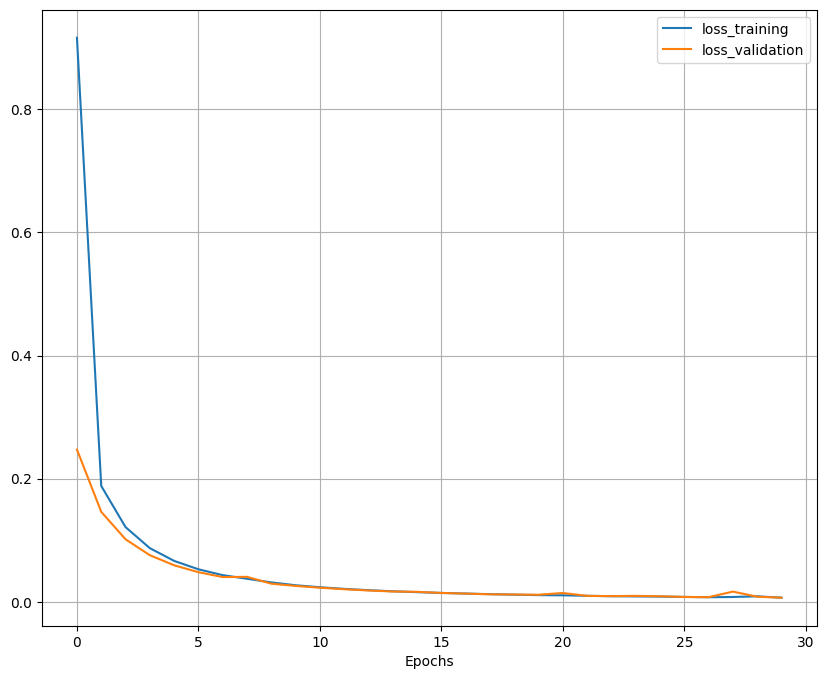

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [ ]:
def test(model, dataloader_test=dataloader_test_AE, denoising=False): # dataloader_test_AE not train
  model.eval()
  total_count_test, n_batches_test, loss = 0, 0, 0
  for idx, (x, x_noisy) in enumerate(dataloader_test):
      if denoising:
        x_rec = model(x_noisy)
      else:
        x_rec = model(x)
      loss += criterion(x_rec, x)
      total_count_test += x.size(0)
      n_batches_test += 1
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}")

In [ ]:
test(Shallow_AE)

Test Loss: 0.00650920


In [ ]:
@torch.no_grad()
def apply_on_test(model, device, denoising=False):
  if denoising:
    x = x_test_noisy.to(device)
  else:
    x = x_test.to(device)
  for layer in model.E_layers:
      x = model.af(layer(x))
  encoded_imgs = x
  y = encoded_imgs
  for layer in model.D_layers[:-1]:
      y = model.af(layer(y))
  if model.act_fun == 'linear':
    decoded_imgs = model.D_layers[-1](y)
  else:
    decoded_imgs = F.sigmoid(model.D_layers[-1](y))
  return (encoded_imgs.to("cpu"), decoded_imgs.to("cpu"))

In [ ]:
encoded_imgs, decoded_imgs = apply_on_test(model=Shallow_AE, device=device)

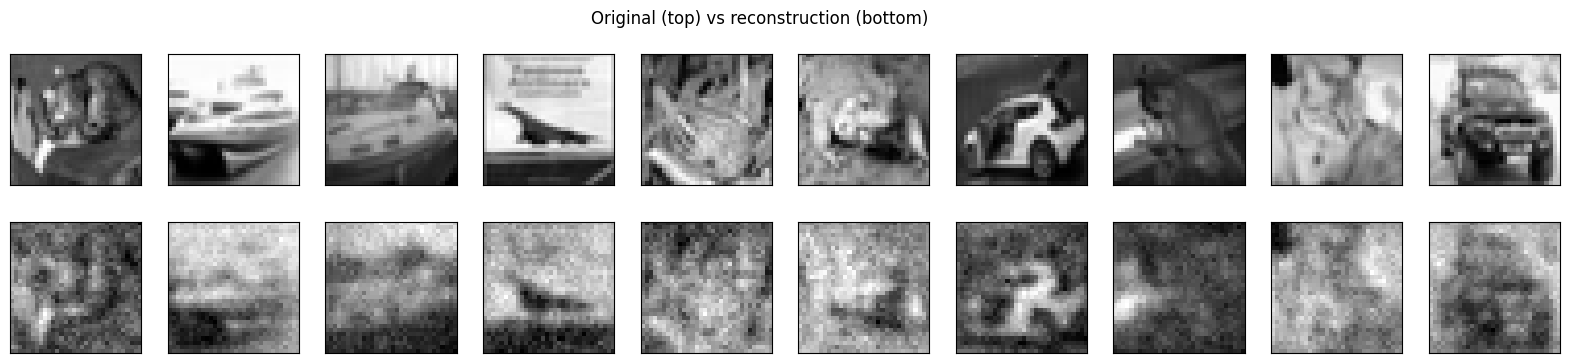

In [ ]:
plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

Comment the results obtained with the shallow linear autoencoder in relation to the ones obtained by the SVD decomposition. Are they different or similar? Why do you think they are so? (hint: consider the theoretical relationship between SVD and a shallow linear autoencoder).

`%STARTEXT`

**Answer**:

The test loss of a shallow linear autoencoder on the given task is 0.00650920, whereas the test loss for SVD with an `ENCODING_DIM` of 256 is 0.00153.

The images obtained with the two techniques does not look similar since the two test MSE, considering the same encoding dimension, are really different. Indeed the outputs of the linear autoencoder look more noisy than the ones reconstructed by the SVD, since linear autoencoders adopt a probabilistic approach. Moreover in some output images from the autoencoder is even difficult to recognize the object represented. Probably, increasing the value of the encoding dimension, it is possible to have a better reconstruction.

Comparing the results, we can observe that the test loss achieved by SVD is significantly lower than that of the shallow linear autoencoder. A lower test loss indicates a better reconstruction quality, meaning that the SVD approach is able to more accurately reconstruct the input data compared to the shallow linear autoencoder.

Considering their theoretical relationship, SVD is a matrix factorization technique that provides an optimal low-rank approximation of the input data. It captures the most significant information in the data by selecting the most significant singular values and their corresponding singular vectors. This property allows SVD to effectively represent the input data with a lower-dimensional encoding. On the other hand, the shallow linear autoencoder used linear transformations to encode and decode the data. While it can still capture important features, it may struggle to capture complex relationships in the data compared to SVD.

The notable difference in test loss suggests that SVD has been more successful in extracting and representing the essential information from the data in a lower-dimensional space, resulting in a more accurate reconstruction. However, it is important to note that these are not general results, since the specific performance of these methods can vary depending on the dataset, the dimensionality of the encoding, and the specific implementation details.

In fact, in terms of images, the outputs of the linear autoencoder look more noisy than the ones reconstructed by the SVD, since linear autoencoders adopt a probabilistic approach. Moreover in some output images from the autoencoder is even difficult to recognize the object represented. Undoubtedly, increasing the value of the encoding dimension, it is possible to get better results.

Considering these outcomes, if the primary goal is to achieve the best possible reconstruction performance, especially for datasets with complex nonlinear relationships, SVD might be a more suitable choice.

`%ENDTEXT`

# [TO COMPLETE] Shallow non-linear Autoencoder

**[TO COMPLETE]**: replicate the code of the previous exercise but in this case, instead of using linear activation functions use non-linear ones. Choose the most appropriate non-linear function, and motivate your choice in the last cell of this section. Discuss the results you obtained in relation to those obtained with the Shallow Linear Autoencoder.

`%STARTCODE`

In [ ]:
### TO COMPLETE [START] ###
# Define shallow non-linear AE model and training hyperparameters
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256] # same encoder layers as shallow linear AE
DEC_LAYERS = [] # same decoder layers as shallow linear AE
ACT_FUN = 'sigmoid' # sigmoid as activation function
lr = 0.005 # same learning rate as shallow linear AE
epochs = 30 # same epochs as shallow linear AE
### TO COMPLETE [END] ###

Shallow_non_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(Shallow_non_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               263,168
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
Total mult-adds (M): 269.09
Input size (MB): 2.10
Forward/backward pass size (MB): 5.24
Params size (MB): 2.10
Estimated Total Size (MB): 9.44

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Shallow_non_AE.parameters(), lr=lr)

In [ ]:
start = timer()
loss_train, loss_val = train(Shallow_non_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.04226823 ---------------- Val_Acc: Val_Loss: 0.02887475
epoch: 2 -> Loss: 0.02367873 ---------------- Val_Acc: Val_Loss: 0.01917046
epoch: 3 -> Loss: 0.01803579 ---------------- Val_Acc: Val_Loss: 0.01548665
epoch: 4 -> Loss: 0.01461420 ---------------- Val_Acc: Val_Loss: 0.01308607
epoch: 5 -> Loss: 0.01364298 ---------------- Val_Acc: Val_Loss: 0.01906059
epoch: 6 -> Loss: 0.01227837 ---------------- Val_Acc: Val_Loss: 0.01103666
epoch: 7 -> Loss: 0.01081758 ---------------- Val_Acc: Val_Loss: 0.01008528
epoch: 8 -> Loss: 0.01022051 ---------------- Val_Acc: Val_Loss: 0.00944211
epoch: 9 -> Loss: 0.00964861 ---------------- Val_Acc: Val_Loss: 0.00892132
epoch: 10 -> Loss: 0.00936970 ---------------- Val_Acc: Val_Loss: 0.00857455
epoch: 11 -> Loss: 0.00893210 ---------------- Val_Acc: Val_Loss: 0.00897683
epoch: 12 -> Loss: 0.00864745 ---------------- Val_Acc: Val_Loss: 0.00831533
epoch: 13 -> Loss: 0.00839061 ---------------- Val_Acc: Val_Loss: 0.00778870
epoch: 1

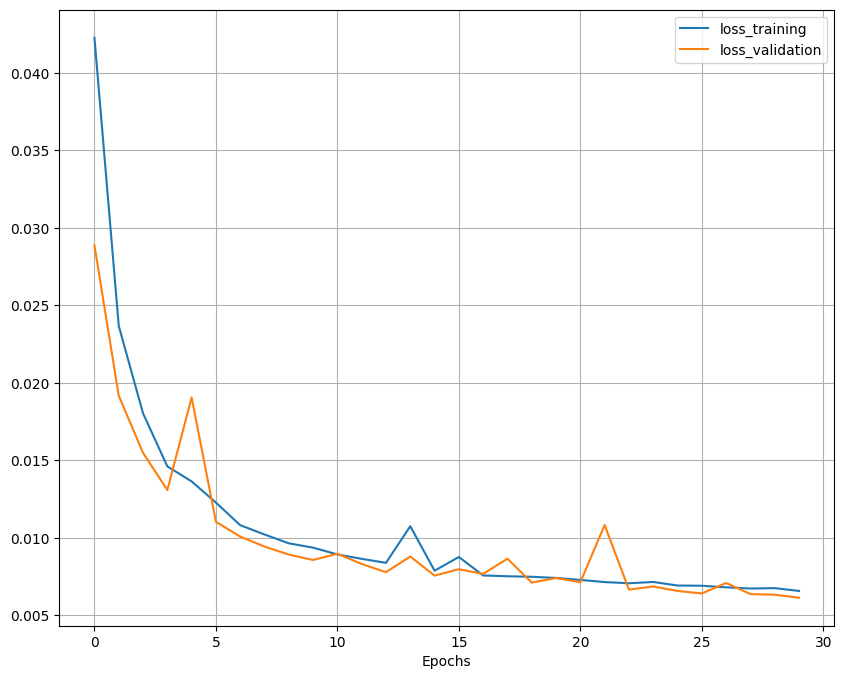

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [ ]:
test(Shallow_non_AE)

Test Loss: 0.00613534


In [ ]:
encoded_imgs, decoded_imgs = apply_on_test(model=Shallow_non_AE, device=device)

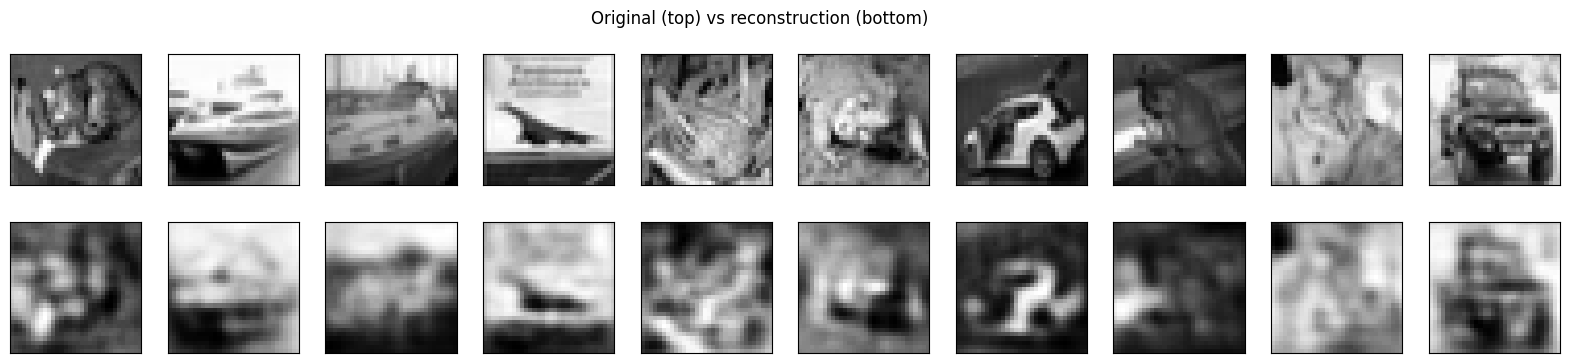

In [ ]:
plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

`%ENDCODE`

Discuss the results you obtained with the activation functions you have tested and also motivate your choice. Compare your results to the ones obtained with the Shallow Linear Autoencoder.

`%STARTEXT`

**Answer**:

In the following table, the tested activation functions on the shallow non-linear autoencoder and their respective test MSE are reported.

|Tested activation functions: Shallow Non-Linear AE|Test MSE|
|-|-|
|sigmoid|0.00613534|
|ReLU|0.02782230|
|tanh|0.01200375|
|leaky ReLU|0.00913362|

As can be seen frome the table above, the best non-linear activation function seems to be the sigmoid. This may indicate that the shallow non-linear autoencoder with sigmoid activation was able to reconstruct the input data relatively well, as the test MSE is comparable to that of the shallow linear autoencoder.

The superior performance of the shallow non-linear autoencoder compared to the shallow linear autoencoder can be attributed to the following factors.

* **Non-linear representation**: the non-linear activation functions used in the shallow non-linear autoencoder enable the model to capture and represent complex non-linear relationships present in the data. This allows the autoencoder to learn more expressive and informative representations compared to the linear activation function used in the shallow linear autoencoder. By introducing non-linear transformations, the shallow non-linear autoencoder can better model intricate patterns and capture higher-order dependencies, leading to improved performance;

* **Enhanced reconstruction capability**: the non-linear activation function facilitates the reconstruction process in the shallow non-linear autoencoder by enabling it to better approximate the input data. Non-linear functions can handle the inherent non-linearities and variations in the data, allowing for more accurate reconstruction. This enhanced reconstruction capability of the shallow non-linear autoencoder can lead to lower reconstruction errors and a more faithful representation of the input data;

* **Increased model flexibility**: the non-linear activation function offers greater flexibility to the shallow non-linear autoencoder by allowing it to adapt and learn more complex mappings between the input and encoded representations. This increased flexibility enables the autoencoder to better capture and represent the underlying structure of the data, leading to improved performance.

The performances of all three models, considering the same encoding dimension parameter are listed in the following.

|Model|Test MSE|
|-|-|
|SVD|0.00153|
|Shallow Linear Autoencoder|0.00650920|
|Shallow Non-Linear Autoencoder (sigmoid)|0.00613534|

Overall, the results demonstrate that the SVD model outperformed both the shallow linear autoencoder and the shallow non-linear autoencoder in terms of test MSE.

`%ENDTEXT`

# [TO COMPLETE] Deep Autoencoder

**[TO COMPLETE]**: define a deep version of the Autoencoder defined above. The autoencoder has to **use at least $5$ layers**. The model will use 𝑛 layers for encoding, and $n-1$ for decoding. The layers sizes of the encoding part decrease at each layer (e.g. `IN_DIM` → $k$ → $k/2$, where $k/2$ is the arbitrarly chosen encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e. $k$ → `IN_DIM`, the resulting overall structure recalls an hourglass!). Try different hyperparameters configurations and write a short report of your experiments below. Leave the best execution in the code cells.

`%STARTCODE`

In [ ]:
### TO COMPLETE [START] ###
# Define deep AE model and training hyperparameters
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256, 128] # best choice of encoding layer sizes
DEC_LAYERS = [128] # mirrored layer sizes for decoding
ACT_FUN = 'sigmoid' # sigmoid as activation function
lr = 0.005 # learning rate as before
epochs = 30 # number of epochs as before
### TO COMPLETE [END] ###

DEEP_non_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(DEEP_non_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
│    └─Linear: 2-2                       [512, 128]                32,896
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-3                       [512, 128]                16,512
│    └─Linear: 2-4                       [512, 1024]               132,096
Total params: 443,904
Trainable params: 443,904
Non-trainable params: 0
Total mult-adds (M): 227.28
Input size (MB): 2.10
Forward/backward pass size (MB): 6.29
Params size (MB): 1.78
Estimated Total Size (MB): 10.16

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DEEP_non_AE.parameters(), lr=lr)

In [ ]:
start = timer()
loss_train, loss_val = train(DEEP_non_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.05457642 ---------------- Val_Acc: Val_Loss: 0.04982516
epoch: 2 -> Loss: 0.04215717 ---------------- Val_Acc: Val_Loss: 0.03662257
epoch: 3 -> Loss: 0.03746346 ---------------- Val_Acc: Val_Loss: 0.03453181
epoch: 4 -> Loss: 0.03338682 ---------------- Val_Acc: Val_Loss: 0.02986971
epoch: 5 -> Loss: 0.02995486 ---------------- Val_Acc: Val_Loss: 0.02898342
epoch: 6 -> Loss: 0.02901722 ---------------- Val_Acc: Val_Loss: 0.02846739
epoch: 7 -> Loss: 0.02855713 ---------------- Val_Acc: Val_Loss: 0.02784007
epoch: 8 -> Loss: 0.02796528 ---------------- Val_Acc: Val_Loss: 0.02663741
epoch: 9 -> Loss: 0.02706560 ---------------- Val_Acc: Val_Loss: 0.02626657
epoch: 10 -> Loss: 0.02685015 ---------------- Val_Acc: Val_Loss: 0.02597764
epoch: 11 -> Loss: 0.02499764 ---------------- Val_Acc: Val_Loss: 0.02423326
epoch: 12 -> Loss: 0.02390238 ---------------- Val_Acc: Val_Loss: 0.02380367
epoch: 13 -> Loss: 0.02326698 ---------------- Val_Acc: Val_Loss: 0.02298804
epoch: 1

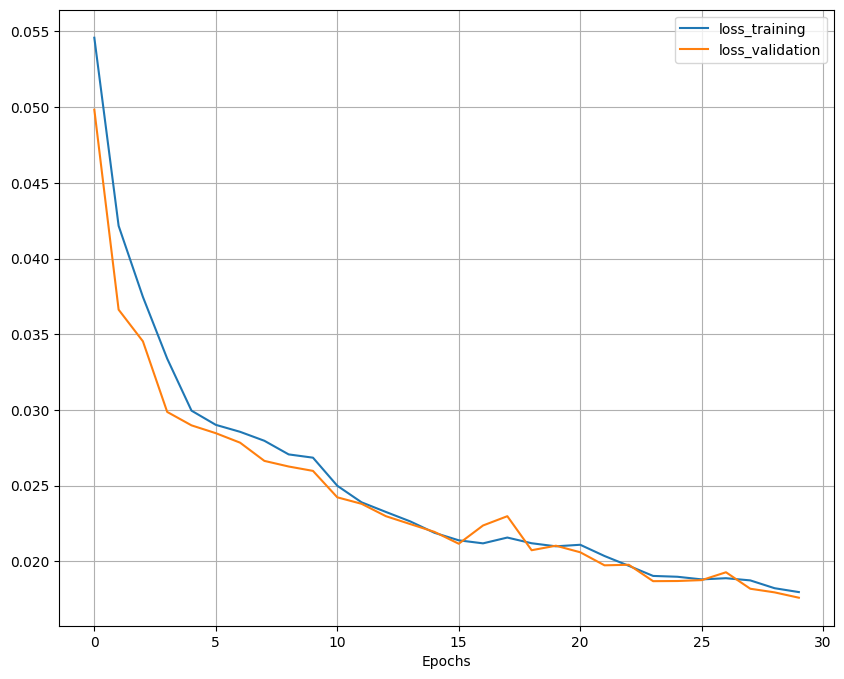

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [ ]:
test(DEEP_non_AE)

Test Loss: 0.01772554


In [ ]:
encoded_imgs, decoded_imgs = apply_on_test(model=DEEP_non_AE, device=device)

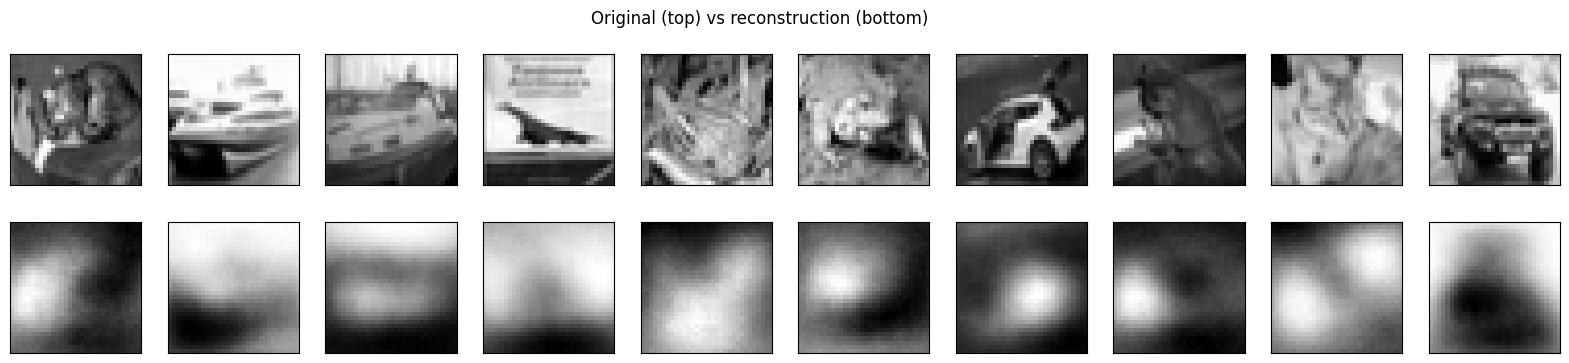

In [ ]:
plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

`%ENDCODE`

Write a short report of the results you obtained trying different hyperparameters configurations.

`%STARTEXT`

**Answer**:

In the following table, the tested Deep AutoEncoders (DAEs) models, their architecture, and their respective test MSE are reported.

|ENC_LAYERS|DEC_LAYERS|ACT_FUN|epochs|Test MSE|
|-|-|-|-|-|
|[256, 128]|[128]|sigmoid|30|0.01772554|
|[512, 256]|[256]|sigmoid|30|0.02014986|
|[128, 64, 32]|[32, 64]|sigmoid|30|0.03821240|
|[256, 128, 64]|[64, 128]|sigmoid|30|0.03266579|
|[512, 256, 128]|[128, 256]|sigmoid|30|0.03167873|
|[256, 128, 64, 32]|[32, 64, 128]|sigmoid|50|0.03213520|
|[512, 256, 128, 64]|[64, 128, 256]|sigmoid|50|0.03235565|
|[512]|[]|sigmoid|30|0.00531204|

As can be seen above, the choice of encoding layers (`ENC_LAYERS`) and decoding layers (`DEC_LAYERS`) affects the performance of the DAE. In general, deeper and wider architectures (with more layers and larger layer sizes) tend to yield better results. The DAEs with more layers (e.g. [512, 256, 128, 64]) generally perform worse than those with fewer layers (e.g. [256, 128]).

The choice of activation function (`ACT_FUN`) as sigmoid appears to be consistent due to the results achieved in previous section.

The number of training epochs (`epochs`) also plays a role in the performance of the DAE. In some cases, increasing the number of epochs can lead to slightly better results, while in others, it doesn't significantly improve the performance.

Based on the above results, it can be observed that the test MSE values for the deep autoencoders are generally higher compared to the non-deep autoencoder. This suggests that the deep autoencoders, with their deeper architectures and increased complexity, may struggle to effectively learn and reconstruct the input data, leading to higher reconstruction errors. The higher capacity and flexibility of deep autoencoders may also make them more prone to overfitting, gradient vanishing/exploding, and sensitivity to hyperparameter tuning.

It is important to note that the performance of deep autoencoders heavily depends on the specific dataset and problem. In some cases, deep autoencoders can outperform non-deep autoencoders by capturing more intricate features and representations. However, in this particular case, the non-deep autoencoder appears to have achieved better results, likely due to its simpler architecture and better generalization ability (as the last tested AE).

Indeed, the last tested autoencoder falls outside the scope of the proposed question. It serves as an additional model to further understand the differences between deep and non-deep autoencoders in terms of their performance.

However, among the tested DAEs, the one with the following architecture emerged as the best performer.

* `ENC_LAYERS` = [256, 128]
* `DEC_LAYERS` = [128]
* `ACT_FUN` = sigmoid
* `epochs` = 30




`%ENDTEXT`

# [TO COMPLETE] Shallow Denoising Autoencoder

**[TO COMPLETE]**: let's now use a shallow autoencoder to denoise the input data. We have defined a Dataloader able to return a noisy version of the input data. You can activate this capability by passing the parameter `denoising=True` to the `train` function.

Run some experiments with different hyperparameters values. You can also re-create the dataloaders at the beginning of the notebook and test what happens if you increase the noise level above $0.1$. Write a short report of your findings below.

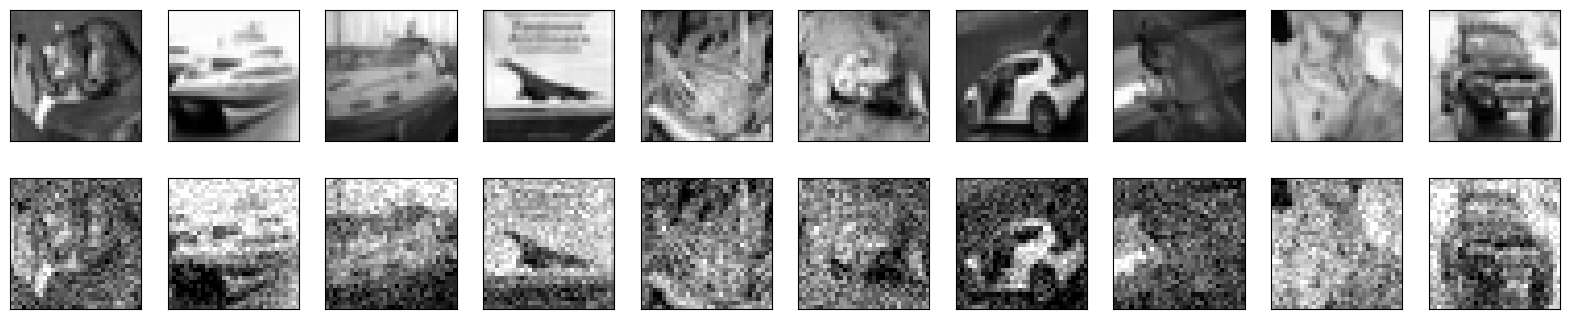

In [ ]:
plot_img(10, [x_test, x_test_noisy])

`%STARTCODE`

In [ ]:
### TO COMPLETE [START] ###
# Define shallow AE model for denoising and training hyperparameters
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [512] # encoding layer size
DEC_LAYERS = [] # mirrored layer size for decoding
ACT_FUN = 'sigmoid' # [fixed] sigmoid as activation function
lr = 0.005 # [fixed] learning rate as before
epochs = 30 # [fixed] number of epochs as before
### TO COMPLETE [END] ###

SHALLOW_denoising_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(SHALLOW_denoising_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 512]                524,800
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               525,312
Total params: 1,050,112
Trainable params: 1,050,112
Non-trainable params: 0
Total mult-adds (M): 537.66
Input size (MB): 2.10
Forward/backward pass size (MB): 6.29
Params size (MB): 4.20
Estimated Total Size (MB): 12.59

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SHALLOW_denoising_AE.parameters(), lr=lr)

In [ ]:
start = timer()
### TO COMPLETE [START] ###
# Call the training function on noisy data
loss_train, loss_val = train(SHALLOW_denoising_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs, denoising=True)
### TO COMPLETE [END] ###
end = timer()
print(f"Training time in second: {round(end - start)}")

epoch: 1 -> Loss: 0.04183767 ---------------- Val_Acc: Val_Loss: 0.02720134
epoch: 2 -> Loss: 0.02235718 ---------------- Val_Acc: Val_Loss: 0.01949907
epoch: 3 -> Loss: 0.01686471 ---------------- Val_Acc: Val_Loss: 0.01507818
epoch: 4 -> Loss: 0.01500953 ---------------- Val_Acc: Val_Loss: 0.01306259
epoch: 5 -> Loss: 0.01274797 ---------------- Val_Acc: Val_Loss: 0.01592641
epoch: 6 -> Loss: 0.01190340 ---------------- Val_Acc: Val_Loss: 0.01159147
epoch: 7 -> Loss: 0.01144425 ---------------- Val_Acc: Val_Loss: 0.01026744
epoch: 8 -> Loss: 0.01037184 ---------------- Val_Acc: Val_Loss: 0.00982801
epoch: 9 -> Loss: 0.00992722 ---------------- Val_Acc: Val_Loss: 0.00939283
epoch: 10 -> Loss: 0.00968066 ---------------- Val_Acc: Val_Loss: 0.00948290
epoch: 11 -> Loss: 0.00916612 ---------------- Val_Acc: Val_Loss: 0.00871567
epoch: 12 -> Loss: 0.00915791 ---------------- Val_Acc: Val_Loss: 0.00952524
epoch: 13 -> Loss: 0.00855218 ---------------- Val_Acc: Val_Loss: 0.00817945
epoch: 1

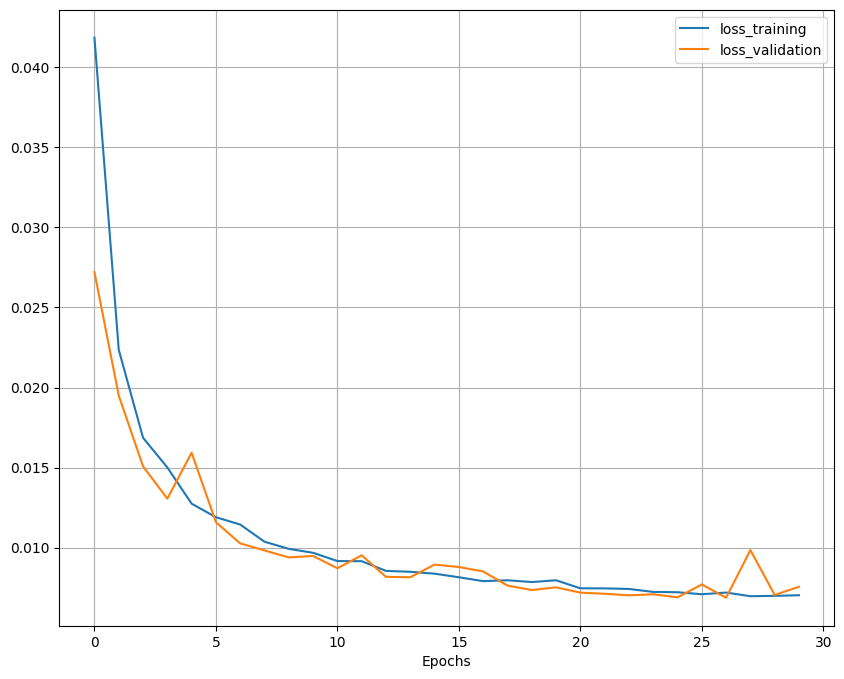

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [ ]:
test(SHALLOW_denoising_AE, denoising=True)

Test Loss: 0.00755593


In [ ]:
encoded_imgs, decoded_imgs = apply_on_test(model=SHALLOW_denoising_AE, device=device, denoising=True)

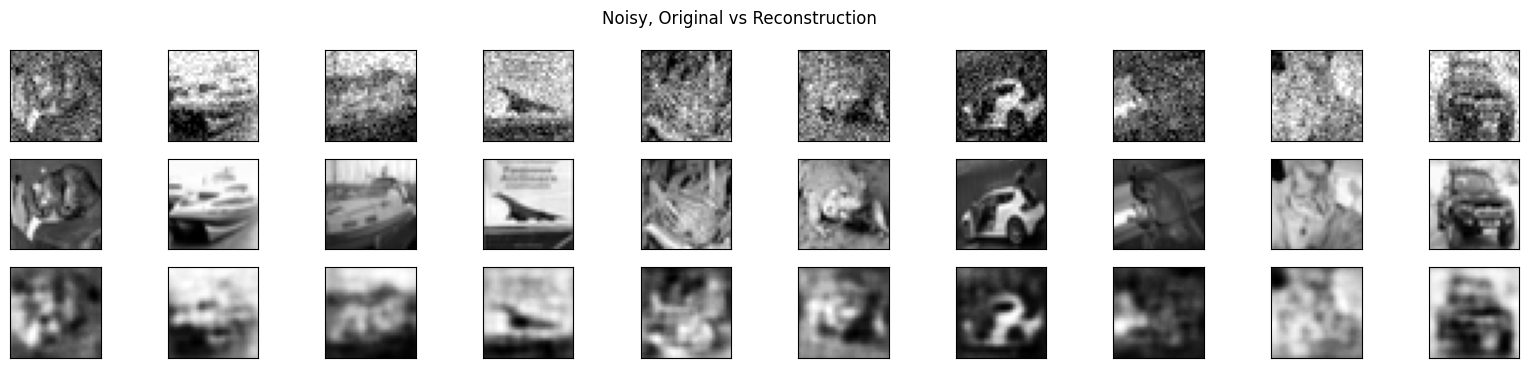

In [ ]:
plot_img(10, [x_test_noisy, x_test, decoded_imgs], title="Noisy, Original vs Reconstruction")

In [ ]:
### TO COMPLETE [START] ###
# Increased noise level
noise_factor = 0.4
### TO COMPLETE [END] ###

In [ ]:
### TO COMPLETE [START] ###
# Increased noise level: dataloaders increased noise_factor
dataloader_train_AE = DataLoader(CustomDataset(train_data, noise_factor, device), batch_size=batch_size)
dataloader_val_AE = DataLoader(CustomDataset(val_data, noise_factor, device), batch_size=batch_size)
dataloader_test_AE = DataLoader(CustomDataset(test_data, noise_factor, device), batch_size=batch_size)
### TO COMPLETE [END] ###

In [ ]:
### TO COMPLETE [START] ###
# Re-instantiate the same model
SHALLOW_denoising_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SHALLOW_denoising_AE.parameters(), lr=lr)
### TO COMPLETE [END] ###

In [ ]:
### TO COMPLETE [START] ###
# Training the same model with an increased noise_factor
start = timer()
loss_train, loss_val = train(SHALLOW_denoising_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs, denoising=True)
end = timer()
print(f"Training time in second: {round(end - start)}")
### TO COMPLETE [END] ###

epoch: 1 -> Loss: 0.04646363 ---------------- Val_Acc: Val_Loss: 0.03349171
epoch: 2 -> Loss: 0.02876237 ---------------- Val_Acc: Val_Loss: 0.02812753
epoch: 3 -> Loss: 0.02328133 ---------------- Val_Acc: Val_Loss: 0.02126065
epoch: 4 -> Loss: 0.02074458 ---------------- Val_Acc: Val_Loss: 0.02109207
epoch: 5 -> Loss: 0.02033613 ---------------- Val_Acc: Val_Loss: 0.01868796
epoch: 6 -> Loss: 0.01826481 ---------------- Val_Acc: Val_Loss: 0.01760988
epoch: 7 -> Loss: 0.01790935 ---------------- Val_Acc: Val_Loss: 0.01701746
epoch: 8 -> Loss: 0.01721871 ---------------- Val_Acc: Val_Loss: 0.01716720
epoch: 9 -> Loss: 0.01674545 ---------------- Val_Acc: Val_Loss: 0.01639518
epoch: 10 -> Loss: 0.01647700 ---------------- Val_Acc: Val_Loss: 0.01597588
epoch: 11 -> Loss: 0.01620974 ---------------- Val_Acc: Val_Loss: 0.01588771
epoch: 12 -> Loss: 0.01598587 ---------------- Val_Acc: Val_Loss: 0.01563193
epoch: 13 -> Loss: 0.01574508 ---------------- Val_Acc: Val_Loss: 0.01537872
epoch: 1

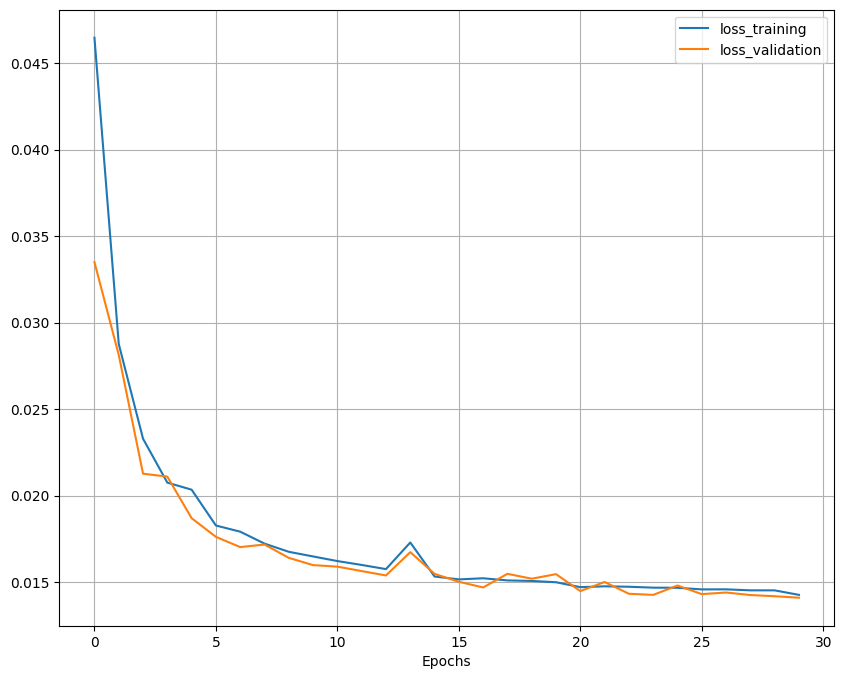

In [ ]:
### TO COMPLETE [START] ###
# Plot the training process results
plot_learning_acc_and_loss(loss_train, loss_val)
### TO COMPLETE [END] ###

In [ ]:
### TO COMPLETE [START] ###
# Test the same model with an increased noise_factor
test(SHALLOW_denoising_AE, denoising=True)
### TO COMPLETE [END] ###

Test Loss: 0.01147911


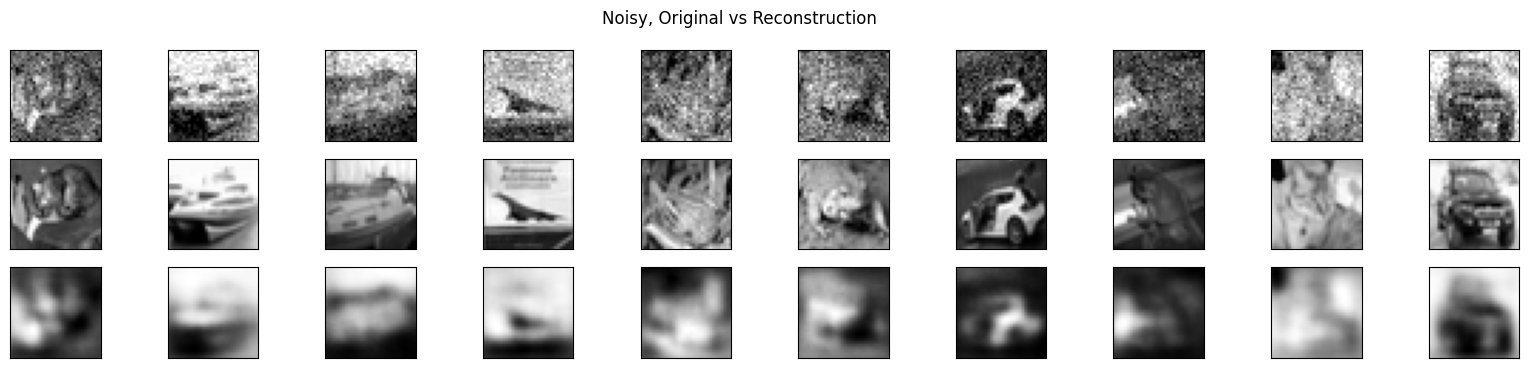

In [ ]:
### TO COMPLETE [START] ###
# Prepare and plot noisy, original and reconstructed images with an incresed noise_factor
encoded_imgs, decoded_imgs = apply_on_test(model=SHALLOW_denoising_AE, device=device, denoising=True)
plot_img(10, [x_test_noisy, x_test, decoded_imgs], title="Noisy, Original vs Reconstruction")
### TO COMPLETE [END] ###

`%ENDCODE`

How strong is the impact of the noise factor on the model's denoising capability? What hyperparameter configuration worked for the noise levels you have tried?

`%STARTEXT`

**Answer**:

The impact of the noise factor on the model's denoising capability is substantial. It determines the intensity of the noise added to the input data, with higher values indicating more significant noise levels.

In the experiments conducted, two noise levels were tested: a standard noise level with a `noise_factor` of 0.1 and an increased noise level with a `noise_factor` of 0.4.

In the following tables, the results of the tests executed with different noise factors are reported.

Standard noise level:

|ENC_LAYERS|DEC_LAYERS|ACT_FUN|epochs|Test MSE|
|-|-|-|-|-|
|[128]|[]|sigmoid|30|0.01424638|
|[256]|[]|sigmoid|30|0.01215305|
|[512]|[]|sigmoid|30|0.00755593|

Increased noise level:

|ENC_LAYERS|DEC_LAYERS|ACT_FUN|epochs|Test MSE|
|-|-|-|-|-|
|[128]|[]|sigmoid|30|0.01715470|
|[256]|[]|sigmoid|30|0.01527087|
|[512]|[]|sigmoid|30|0.01147911|

For the standard noise level (`noise_factor` = 0.1), the following hyperparameter configuration yielded favorable results.

* `ENC_LAYERS` = [512]
* `DEC_LAYERS` = []
* `ACT_FUNC` = sigmoid
* `epochs` = 30

This configuration achieved a test MSE of 0.00755593, demonstrating the model's effective denoising capability in reconstructing the original data from the noisy input. As expected, the performance is lower compared to what was observed in a standard training situation without considering noisy data.

When dealing with the increased noise level (`noise_factor` = 0.4), the same hyperparameter configuration outperformed the others.

* `ENC_LAYERS` = [512]
* `DEC_LAYERS` = []
* `ACT_FUNC` = sigmoid
* `epochs` = 30

It achieved a test MSE of 0.01147911, indicating a significantly improved denoising performance in handling the higher noise level compared to the other tested models. However, it is important to note that, given the increased noise added to the considered data, the performance generally decreases for each tested AE.

In summary, the hyperparameter configuration mentioned above proved to be effective for both the standard and increased noise levels. It exhibited robust denoising capabilities by reducing the noise and successfully reconstructing the original data.

`%ENDTEXT`